In [2]:
from sampling import unadjusted_langevin_algorithm_gpu, metropolis_adjusted_langevin_algorithm_gpu
import numpy as np 
import torch
import matplotlib.pyplot as plt

In [14]:
def potential_vote(z,epsilon=5,r=2):
    z = z.view(-1, 2)
    g_1=z[:,1]-z[:,0]
    g_2=z[:,1]+z[:,0]
    #g_3=2-z[:,1]
    S_1=torch.sigmoid(epsilon*g_1)+torch.sigmoid(epsilon*g_2)
    V_1=torch.sigmoid(epsilon*(S_1-0.5))
    vote_term=torch.sigmoid(epsilon*(V_1-0.5))

    norm=torch.norm(z,p=torch.inf,dim=1)
    init_term=torch.sigmoid((r-norm)*epsilon)

    full_term=vote_term*init_term

    return -torch.log(full_term)

def potential_vote_2_round(z,epsilon=5,r=2):
    z = z.view(-1, 2)
    g_1=z[:,1]-z[:,0]
    g_2=z[:,1]+z[:,0]
    #g_3=2-z[:,1]
    S_1=torch.sigmoid(epsilon*g_1)+torch.sigmoid(epsilon*g_2)
    V_1=torch.sigmoid(epsilon*(S_1-0.5))

    g_3=z[:,0]-1
    g_4=-1-z[:,0]
    S_2=torch.sigmoid(epsilon*g_3)+torch.sigmoid(epsilon*g_4)
    V_2=torch.sigmoid(epsilon*(S_2-0.5))

    vote_term=torch.sigmoid(epsilon*(V_1+V_2-1.5))

    norm=torch.norm(z,p=torch.inf,dim=1)
    init_term=torch.sigmoid((r-norm)*epsilon)

    full_term=vote_term*init_term

    return -torch.log(full_term)

In [52]:
def square_bound(theta,r=2):
    return r-torch.norm(theta,p=torch.inf,dim=1)

def potential_vote_custom(theta,dim=2,init_ineq=lambda x: square_bound(x,r=2), vote_ineq_funcs=[], epsilon=5, rationality=0.5):
    theta=theta.view(-1, dim)
    vote_round_num=len(vote_ineq_funcs)

    init_term=torch.sigmoid(epsilon*init_ineq(theta))

    V=0
    vote_term=1
    for func in vote_ineq_funcs:
        ineqs=func(theta)
        num_vote=ineqs.shape[1]
        #print(num_vote)
        S=torch.sigmoid(epsilon*ineqs).sum(axis=1)
        V+=torch.sigmoid(epsilon*(S-num_vote*rationality+0.5))
    vote_term*=torch.sigmoid(epsilon*(V-vote_round_num + 0.5))

    full_term=vote_term*init_term

    return -torch.log(full_term)

def test_g1(z):
    z = z.view(-1, 2)
    return z[:,1]-z[:,0]

def test_g2(z):
    z = z.view(-1, 2)
    return z[:,1]+z[:,0]

def test_g3(z):
    z = z.view(-1, 2)
    return z[:,0]-1

def test_g4(z):
    z = z.view(-1, 2)
    return -1-z[:,0]


In [6]:
samples_gpu_vote = unadjusted_langevin_algorithm_gpu(lambda z: potential_vote(z,5,2),n_samples=100000,step=0.001,iters=20000)
samples_adj_gpu_vote = metropolis_adjusted_langevin_algorithm_gpu(lambda z: potential_vote(z,5,2),n_samples=100000,step=0.01,iters=1000)

100%|██████████| 1000/1000 [00:07<00:00, 133.54it/s]


In [33]:
theta=torch.rand((1000,2))
test_g1(theta).view(-1,1).shape

torch.Size([1000, 1])

In [53]:
def gen_ineqs_1(theta):
    return torch.concat([test_g1(theta).view(-1,1),test_g2(theta).view(-1,1)],axis=1)

def gen_ineqs_2(theta):
    return torch.concat([test_g3(theta).view(-1,1),test_g4(theta).view(-1,1)],axis=1)

potential_func_custom = lambda theta: potential_vote_custom(theta,dim=2,vote_ineq_funcs=[gen_ineqs_1,gen_ineqs_2])
samples_adj_gpu_vote_custom=metropolis_adjusted_langevin_algorithm_gpu(potential_func_custom
                                                                       ,n_samples=100000,step=0.01,iters=1000)

100%|██████████| 1000/1000 [00:11<00:00, 86.48it/s]


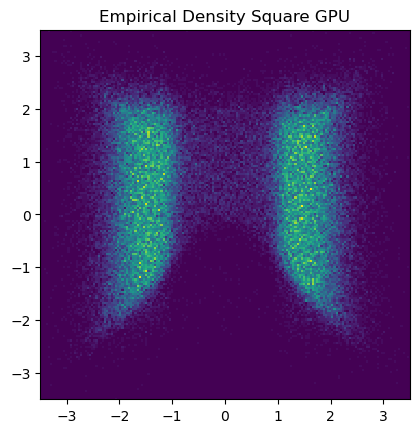

In [54]:
plt.hist2d(samples_adj_gpu_vote_custom[:,0], samples_adj_gpu_vote_custom[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density Square GPU')
plt.show()

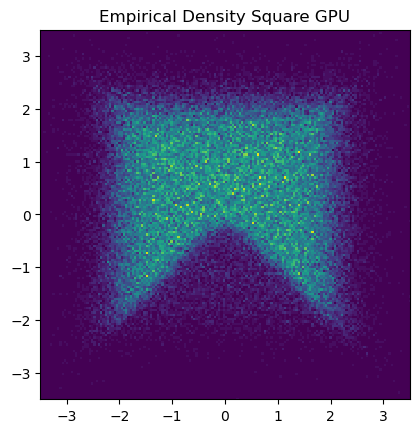

In [5]:
plt.hist2d(samples_gpu_vote[:,0], samples_gpu_vote[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density Square GPU')
plt.show()

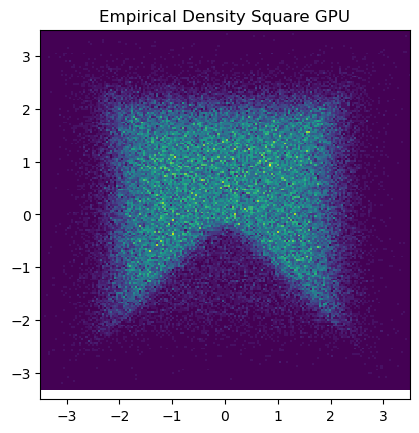

In [7]:
plt.hist2d(samples_adj_gpu_vote[:,0], samples_adj_gpu_vote[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density Square GPU')
plt.show()

In [18]:
samples_gpu_vote = unadjusted_langevin_algorithm_gpu(lambda z: potential_vote_2_round(z,5,2),n_samples=100000,step=0.001,iters=20000)
samples_adj_gpu_vote = metropolis_adjusted_langevin_algorithm_gpu(lambda z: potential_vote_2_round(z,5,2),n_samples=100000,step=0.01,iters=1000)

100%|██████████| 1000/1000 [00:10<00:00, 93.51it/s]


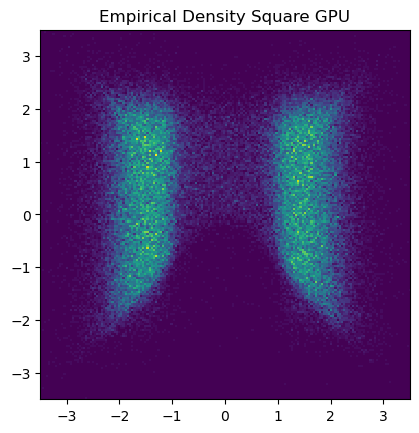

In [16]:
plt.hist2d(samples_gpu_vote[:,0], samples_gpu_vote[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density Square GPU')
plt.show()

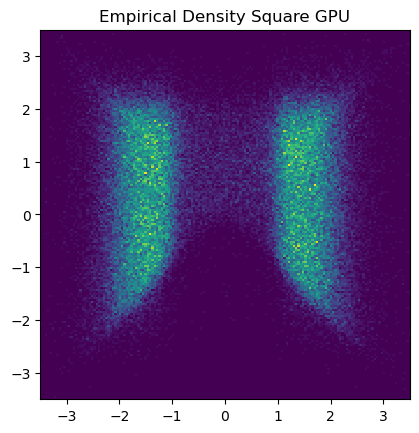

In [17]:
plt.hist2d(samples_adj_gpu_vote[:,0], samples_adj_gpu_vote[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Empirical Density Square GPU')
plt.show()